In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import pickle
import collections
%matplotlib inline
pd.set_option('display.max.columns',None)

In [560]:
df=pd.read_csv('googleplaystore.csv')
print(df.shape)
df.head()

(10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [561]:
#Remove columns which doesn't make sense in rating prediction
df.drop(['App','Genres','Current Ver'],axis=1,inplace=True)
#Check Missing  values
df.isnull().sum()

Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Last Updated         0
Android Ver          3
dtype: int64

#Handle Missing Values

In [562]:
#Remove NA values for Type.
print("Before removing NA the shape of Dataframe is {0}".format(df.shape))
df.dropna(inplace=True)
print("After removing NA the shape of Dataframe is {0}".format(df.shape))

Before removing NA the shape of Dataframe is (10841, 10)
After removing NA the shape of Dataframe is (9364, 10)


In [563]:
df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Last Updated      0
Android Ver       0
dtype: int64

In [564]:
df.dtypes

Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Last Updated       object
Android Ver        object
dtype: object

#Data Cleaning and Preprocessing starts

#### Review should be numeric datatype,instead of  object type .One entry has an alphabetical character ,hence object.Need data cleaning here
#### Size also has aphanumerical characters which needs processing
#### Same scenario with installs ,it has alphanumeric characters
#### Price also needs to be numeric type
#### Instead of using date object ,We will derive a new column suggesting the no. of days between current date and last updated version date

In [565]:
df['Reviews']=df['Reviews'].astype('int')

In [566]:
#Handle Size variable
#Remove + sign from size
#Convert M into KB
def getSize(val):
    val=str(val)
    val=val.lower()
    if('+' in val):
      val=val.strip('+')
    if(val.endswith('m')):
      val=val.strip('m')
      val=(1000)*float(val)
      return val
    elif(val.endswith('k')):
      return float(val.strip('k'))
    else:
      return 0
    
df['Size']=df['Size'].apply(lambda x:getSize(x) )


In [567]:
#Handle Installs variable
df['Installs']=df['Installs'].apply(lambda x : int(x.replace(",","").strip('+')))
#df.drop(['Installs_new'],axis=1,inplace=True)

In [568]:
df.head()


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Android Ver
0,ART_AND_DESIGN,4.1,159,19000.0,10000,Free,0,Everyone,"January 7, 2018",4.0.3 and up
1,ART_AND_DESIGN,3.9,967,14000.0,500000,Free,0,Everyone,"January 15, 2018",4.0.3 and up
2,ART_AND_DESIGN,4.7,87510,8700.0,5000000,Free,0,Everyone,"August 1, 2018",4.0.3 and up
3,ART_AND_DESIGN,4.5,215644,25000.0,50000000,Free,0,Teen,"June 8, 2018",4.2 and up
4,ART_AND_DESIGN,4.3,967,2800.0,100000,Free,0,Everyone,"June 20, 2018",4.4 and up


In [569]:
#Handle Price variable
df['Price']=df['Price'].apply(lambda x : float(x.strip('$')))


In [570]:
df['Last Updated'] = df['Last Updated'].apply(lambda x : pd.to_datetime(x))
#Caluclate new colums
date2=pd.to_datetime('now')
print(date2)
df['Date_Diff']=df['Last Updated'].apply(lambda x: (date2-x).days)
df.drop(['Last Updated'],axis=1,inplace=True)
#df.rename(columns={'Last Updatednew':'Last Updated'},inplace=True)

2021-12-25 03:16:56.167573


In [571]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Android Ver,Date_Diff
0,ART_AND_DESIGN,4.1,159,19000.0,10000,Free,0.0,Everyone,4.0.3 and up,1448
1,ART_AND_DESIGN,3.9,967,14000.0,500000,Free,0.0,Everyone,4.0.3 and up,1440
2,ART_AND_DESIGN,4.7,87510,8700.0,5000000,Free,0.0,Everyone,4.0.3 and up,1242
3,ART_AND_DESIGN,4.5,215644,25000.0,50000000,Free,0.0,Teen,4.2 and up,1296
4,ART_AND_DESIGN,4.3,967,2800.0,100000,Free,0.0,Everyone,4.4 and up,1284


# Time For Data Analysis


In [ ]:
df.dtypes

Category           object
Rating            float64
Reviews             int64
Size              float64
Installs            int64
Type               object
Price             float64
Content Rating     object
Android Ver        object
Date_Diff           int64
dtype: object

In [572]:
numerical_cols=[]
cat_cols=[]
target_col=[]
for feature ,typeVal in zip(df.dtypes.index,df.dtypes):
  if typeVal=='object':
    cat_cols.append(feature)
  elif feature=='Rating':
    target_col.append(feature)
  else:
    numerical_cols.append(feature)

print("Categorical columns are :{}".format(cat_cols))
print("Numerical columns are :{}".format(numerical_cols))
print("Target columns are :{}".format(target_col))

Categorical columns are :['Category', 'Type', 'Content Rating', 'Android Ver']
Numerical columns are :['Reviews', 'Size', 'Installs', 'Price', 'Date_Diff']
Target columns are :['Rating']


#Check correlation between Numerical columns:
Rating and No of installation are positively correlated

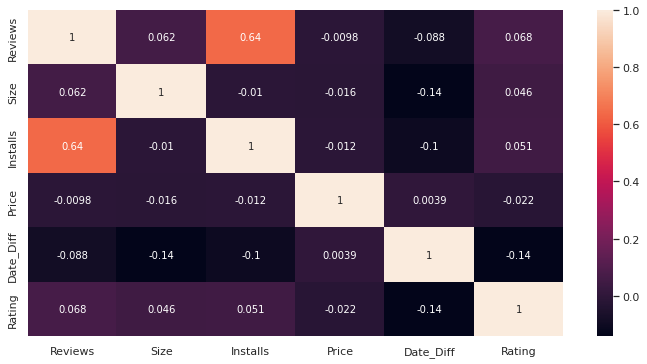

In [ ]:

plt.figure(figsize=(12,6))
test_cols=numerical_cols.copy()
test_cols.extend(target_col)
sns.heatmap(df[test_cols].corr(),annot=True)

#Check distrbution of Numerical columns

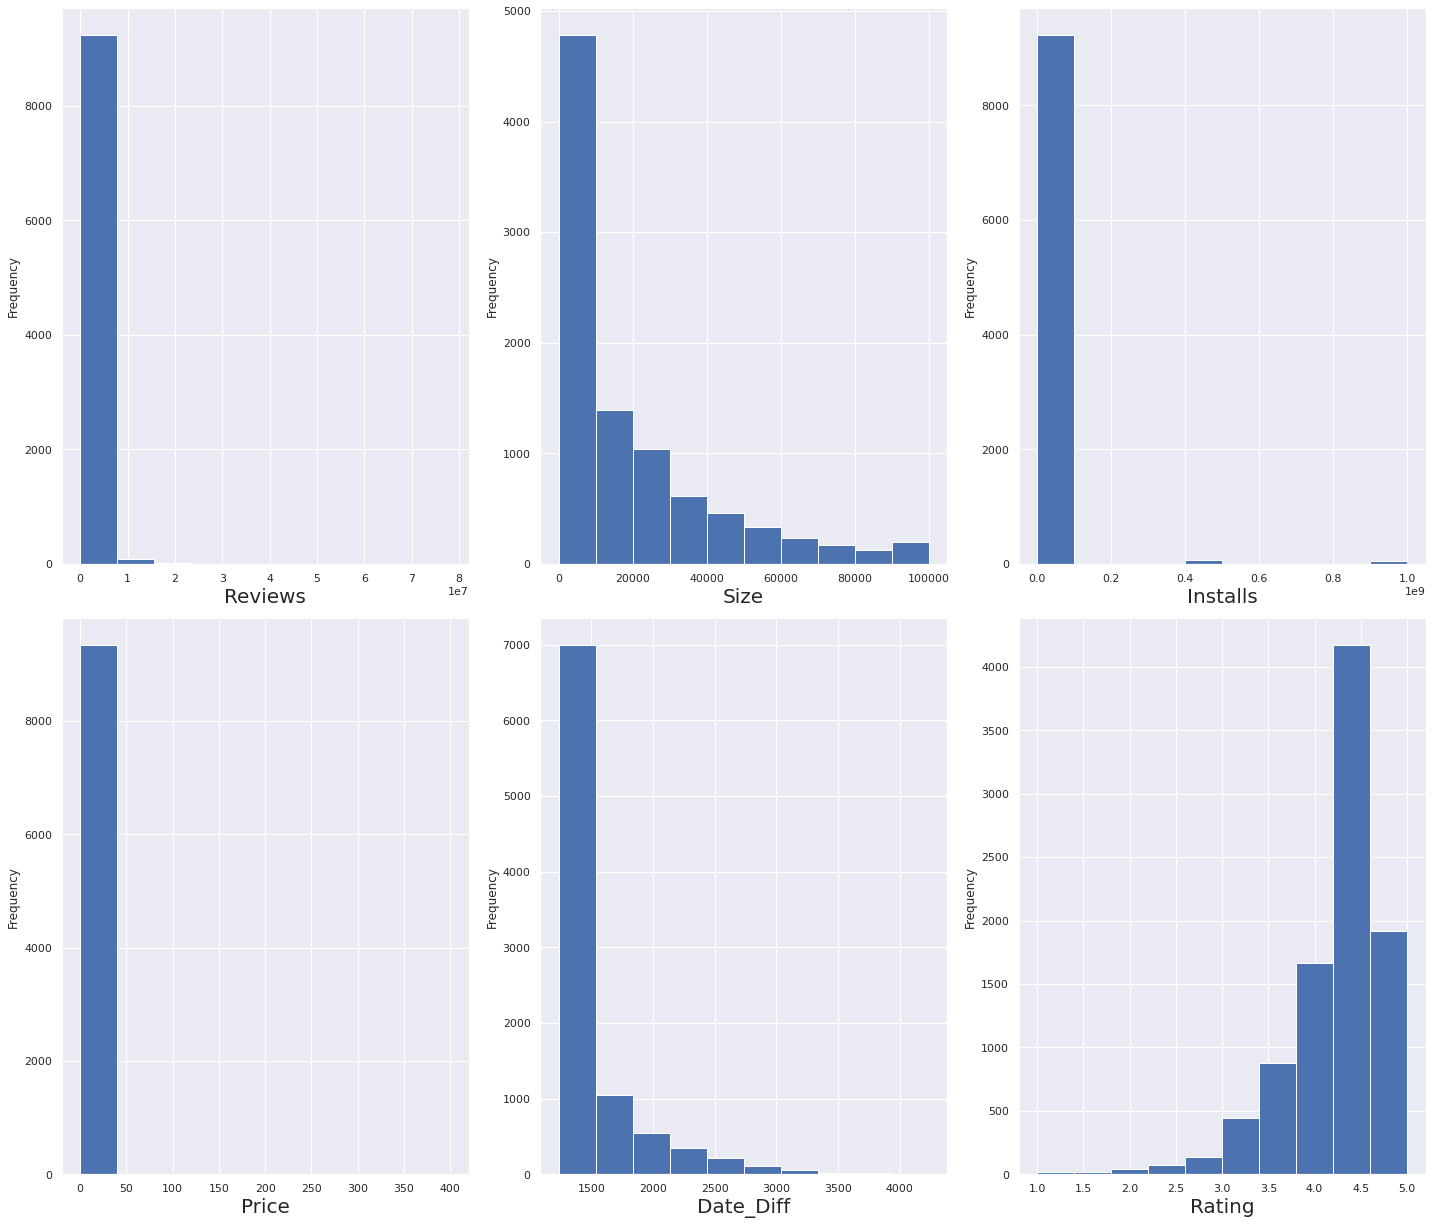

In [ ]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in test_cols:
    if plotnumber<=6 :
        ax = plt.subplot(3,3,plotnumber)
        df[column].plot(kind='hist')
        #sns.distplot(df[column],hist=False)
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.tight_layout()

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Android Ver,Date_Diff
0,ART_AND_DESIGN,4.1,159,19000.0,10000,Free,0.0,Everyone,4.0.3 and up,1448
1,ART_AND_DESIGN,3.9,967,14000.0,500000,Free,0.0,Everyone,4.0.3 and up,1440
2,ART_AND_DESIGN,4.7,87510,8700.0,5000000,Free,0.0,Everyone,4.0.3 and up,1242
3,ART_AND_DESIGN,4.5,215644,25000.0,50000000,Free,0.0,Teen,4.2 and up,1296
4,ART_AND_DESIGN,4.3,967,2800.0,100000,Free,0.0,Everyone,4.4 and up,1284


# Scatterplot between Variables

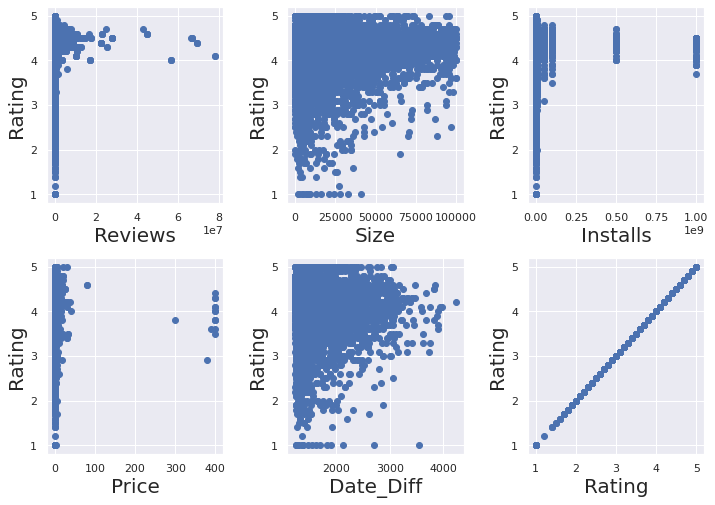

In [ ]:
plt.figure(figsize=(10,10), facecolor='white')
plotnumber = 1

for column in test_cols:
    if plotnumber<=6 :
        ax = plt.subplot(3,3,plotnumber)
        plt.scatter(df[column],df['Rating'])
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Rating',fontsize=20)
    plotnumber+=1
plt.tight_layout()

#Couldn't find any strong linear relationships

# Box Plot for all numerical variables

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

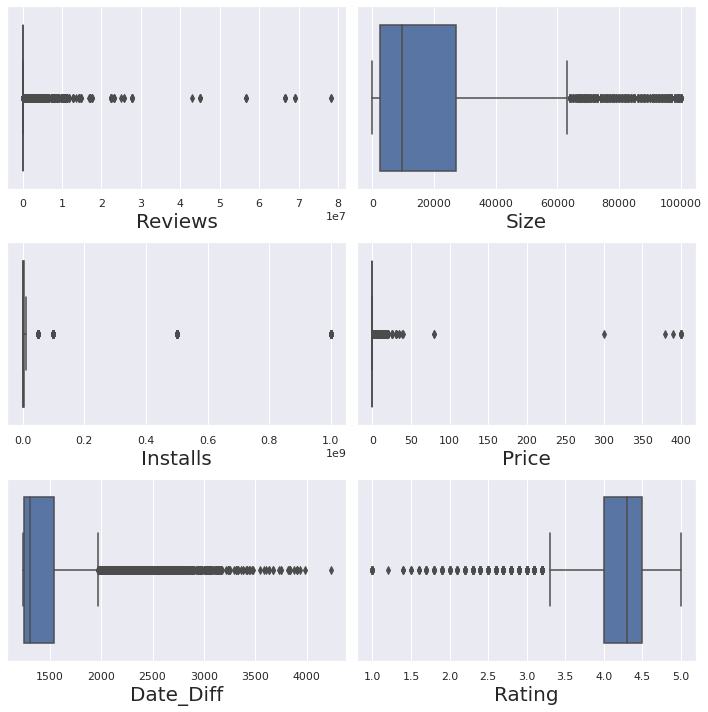

In [ ]:
# let's see how data is distributed for every column
plt.figure(figsize=(10,10), facecolor='white')
plotnumber = 1

for column in test_cols:
    if plotnumber<=6 :
        ax = plt.subplot(3,2,plotnumber)
        sns.boxplot(df[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.tight_layout()

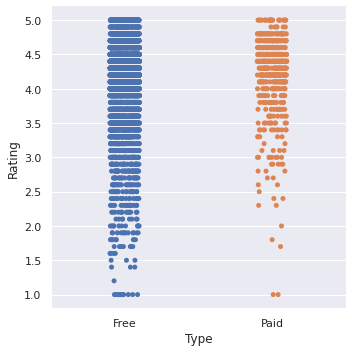

In [ ]:
sns.catplot(x='Type',y='Rating',data=df) 
#Paid Apps have few low ratings

In [ ]:
df.to_csv('cleanedratings.csv',index=False)

# Data preprocessing starts

In [573]:
#Handle android version
#As we can see there are lot of categories for supported Android version. SO we will take top 10 most frequent versions
top10_androidv=df['Android Ver'].value_counts().sort_values(ascending=False).head(10).index
top10_androidv=list(top10_androidv)
print(top10_androidv)

['4.1 and up', 'Varies with device', '4.0.3 and up', '4.0 and up', '4.4 and up', '2.3 and up', '5.0 and up', '4.2 and up', '2.3.3 and up', '3.0 and up']


In [574]:
for versions in top10_androidv:
    df[versions]=np.where(df['Android Ver']==versions,1,0)
df.drop(['Android Ver'],axis=1,inplace=True)


In [575]:
#Applying same logic for Categories
df['Category'].value_counts().sort_values(ascending=False)
top10_categories=df['Category'].value_counts().sort_values(ascending=False).head(10).index
top10_categories=list(top10_categories)
print(top10_categories)
for category in top10_categories:
    df[category]=np.where(df['Category']==category,1,0)
df.drop(['Category'],axis=1,inplace=True)

['FAMILY', 'GAME', 'TOOLS', 'PRODUCTIVITY', 'MEDICAL', 'COMMUNICATION', 'FINANCE', 'SPORTS', 'PHOTOGRAPHY', 'LIFESTYLE']


In [576]:
df.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Date_Diff,4.1 and up,Varies with device,4.0.3 and up,4.0 and up,4.4 and up,2.3 and up,5.0 and up,4.2 and up,2.3.3 and up,3.0 and up,FAMILY,GAME,TOOLS,PRODUCTIVITY,MEDICAL,COMMUNICATION,FINANCE,SPORTS,PHOTOGRAPHY,LIFESTYLE
0,4.1,159,19000.0,10000,Free,0.0,Everyone,1448,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.9,967,14000.0,500000,Free,0.0,Everyone,1440,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,8700.0,5000000,Free,0.0,Everyone,1242,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,25000.0,50000000,Free,0.0,Teen,1296,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4.3,967,2800.0,100000,Free,0.0,Everyone,1284,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [577]:
#Create dummy Variables for Type and Content Rating
for col in ['Type','Content Rating']:
    df=pd.get_dummies(df, columns=[col], prefix=[col], drop_first=True)
df.head()

,Rating,Reviews,Size,Installs,Price,Date_Diff,4.1 and up,Varies with device,4.0.3 and up,4.0 and up,4.4 and up,2.3 and up,5.0 and up,4.2 and up,2.3.3 and up,3.0 and up,FAMILY,GAME,TOOLS,PRODUCTIVITY,MEDICAL,COMMUNICATION,FINANCE,SPORTS,PHOTOGRAPHY,LIFESTYLE,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4.1,159,19000.0,10000,0.0,1448,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3.9,967,14000.0,500000,0.0,1440,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,4.7,87510,8700.0,5000000,0.0,1242,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4.5,215644,25000.0,50000000,0.0,1296,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4.3,967,2800.0,100000,0.0,1284,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#Scaling the dataset

In [578]:
#Scaling the numerical columns
scaler =StandardScaler()
#numerical_cols.remove('Rating')
print(numerical_cols)
X_scaled = scaler.fit_transform(df[numerical_cols])
X_scaled

['Reviews', 'Size', 'Installs', 'Price', 'Date_Diff']


array([[-1.63475738e-01,  2.27260498e-03, -1.96084315e-01,
        -6.07541331e-02, -9.74341591e-02],
       [-1.63218757e-01, -2.14985083e-01, -1.90714024e-01,
        -6.07541331e-02, -1.17611322e-01],
       [-1.35694118e-01, -4.45278233e-01, -1.41395017e-01,
        -6.07541331e-02, -6.16996099e-01],
       ...,
       [-1.63525035e-01, -6.66881075e-01, -1.96192817e-01,
        -6.07541331e-02, -5.51420320e-01],
       [-1.63490050e-01, -8.23306610e-01, -1.96182953e-01,
        -6.07541331e-02,  2.63657139e+00],
       [-3.68464304e-02,  2.27260498e-03, -8.65961214e-02,
        -6.07541331e-02, -5.99341082e-01]])

In [581]:
#Adding Categorical Variables to them 
newcat_cols=list(df.columns[6:])
print(newcat_cols)
X_scaled = np.column_stack((X_scaled, df[newcat_cols].values))
print("Shape after adding categorical value")
X_scaled.shape

['4.1 and up', 'Varies with device', '4.0.3 and up', '4.0 and up', '4.4 and up', '2.3 and up', '5.0 and up', '4.2 and up', '2.3.3 and up', '3.0 and up', 'FAMILY', 'GAME', 'TOOLS', 'PRODUCTIVITY', 'MEDICAL', 'COMMUNICATION', 'FINANCE', 'SPORTS', 'PHOTOGRAPHY', 'LIFESTYLE', 'Type_Paid', 'Content Rating_Everyone', 'Content Rating_Everyone 10+', 'Content Rating_Mature 17+', 'Content Rating_Teen', 'Content Rating_Unrated']
Shape after adding categorical value


(9364, 31)

In [585]:
total_cols=numerical_cols+newcat_cols
print(total_cols)
print(len(total_cols))

['Reviews', 'Size', 'Installs', 'Price', 'Date_Diff', '4.1 and up', 'Varies with device', '4.0.3 and up', '4.0 and up', '4.4 and up', '2.3 and up', '5.0 and up', '4.2 and up', '2.3.3 and up', '3.0 and up', 'FAMILY', 'GAME', 'TOOLS', 'PRODUCTIVITY', 'MEDICAL', 'COMMUNICATION', 'FINANCE', 'SPORTS', 'PHOTOGRAPHY', 'LIFESTYLE', 'Type_Paid', 'Content Rating_Everyone', 'Content Rating_Everyone 10+', 'Content Rating_Mature 17+', 'Content Rating_Teen', 'Content Rating_Unrated']
31



# The Input narray is in the order 


```
# This is formatted as code
```

['Reviews', 'Size', 'Installs', 'Price', 'Date_Diff', '4.1 and up', 'Varies with device', '4.0.3 and up', '4.0 and up', '4.4 and up', '2.3 and up', '5.0 and up', '4.2 and up', '2.3.3 and up', '3.0 and up', 'FAMILY', 'GAME', 'TOOLS', 'PRODUCTIVITY', 'MEDICAL', 'COMMUNICATION', 'FINANCE', 'SPORTS', 'PHOTOGRAPHY', 'LIFESTYLE', 'Type_Paid', 'Content Rating_Everyone', 'Content Rating_Everyone 10+', 'Content Rating_Mature 17+', 'Content Rating_Teen', 'Content Rating_Unrated']




In [586]:
X_scaled[0:1]


array([[-0.16347574,  0.0022726 , -0.19608432, -0.06075413, -0.09743416,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

Divide dataset into training test split

In [587]:
y=df['Rating']
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.20,random_state=40)

In [588]:
x_train.shape,x_test.shape

((7491, 31), (1873, 31))

# Develop ML model to predict App Ratings. We will develop KNN and ForestRegressor as there are many outliers present

In [589]:

model1 = ExtraTreesRegressor()
model1.fit(x_train,y_train)

ExtraTreesRegressor()

In [590]:
modelList=[]
metrics={}
metrics['modelName']='Extra Tree Regressor'
pred=model1.predict(x_test) #predicting values of y for all the xtest rows
metrics['testRMSE']=mean_squared_error(y_test,pred)**0.5
modelList.append(metrics)
modelList

[{'modelName': 'Extra Tree Regressor', 'testRMSE': 0.5090748693831586}]

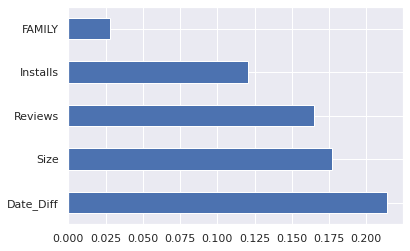

In [593]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model1.feature_importances_,total_cols)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [594]:
#CReate Random Forest Regressor

regressor=RandomForestRegressor()



In [595]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2)
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   6.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   4.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   4.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_e

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
best_params=rf_random.best_params_
best_params

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 600}

In [ ]:
rfregressor = RandomForestRegressor(min_samples_leaf = best_params['min_samples_leaf']
                                     ,min_samples_split= best_params['min_samples_split'],
                                     n_estimators =best_params['n_estimators'],max_features=best_params['max_features'],
                                    max_depth=best_params['max_depth']
                                    )
rfregressor.fit(x_train,y_train)



RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=10,
                      n_estimators=600)

In [ ]:
pred=rfregressor.predict(x_test) #predicting values of y for all the xtest rows
mse=mean_squared_error(y_test,pred)
rmse=round(mse**0.5,2)
metrics={}
metrics['modelName']='Random Forest Regressor'
 #predicting values of y for all the xtest rows
metrics['testRMSE']=rmse
modelList.append(metrics)
modelList

[{'modelName': 'Extra Tree Regressor', 'testRMSE': 0.5091794289543339},
 {'modelName': 'KNN Regressor', 'testRMSE': 0.52},
 {'modelName': 'Random Forest Regressor', 'testRMSE': 0.47}]

In [596]:
#Create KNN Model
# Look at the 15 closest neighbors
knn_model = KNeighborsRegressor(n_neighbors=20)
# Find the mean accuracy of knn regression using X_test and y_test
knn_model.fit(x_train, y_train)


KNeighborsRegressor(n_neighbors=20)

In [ ]:
#Choose optimal value of K

In [600]:
metrics={}
pred=knn_model.predict(x_test) #predicting values of y for all the xtest rows
mse=mean_squared_error(y_test,pred)
rmse=round(mse**0.5,2)
metrics['modelName']='KNN Regressor'
 #predicting values of y for all the xtest rows
metrics['testRMSE']=rmse
modelList.append(metrics)
modelList

[{'modelName': 'Extra Tree Regressor', 'testRMSE': 0.5090748693831586},
 {'modelName': 'KNN Regressor', 'testRMSE': 0.52},
 {'modelName': 'Random Forest Regressor', 'testRMSE': 0.47}]

# KNN model has the lowest RMSE

#Save the model and use for further predictions

In [601]:
# saving the model to the local file system
filename1 = 'regression_model.pickle'
pickle.dump(knn_model, open(filename1, 'wb'))
fileName2= 'scaler_transformation.pickle'
pickle.dump(scaler, open(fileName2, 'wb'))
# prediction using the saved model

In [607]:
#Save top10 Categories and to10 version
filename1 = 'top10version.pickle'
pickle.dump(top10_androidv, open(filename1, 'wb'))
fileName2= 'top10categories.pickle'
pickle.dump(top10_categories, open(fileName2, 'wb'))

In [638]:
#Save dummy columns
filename3='dummyColumns.pickle'
pickle.dump(list(df.columns[26:]), open(filename3, 'wb'))


In [602]:
print("I/P features must be in following order :")
total_cols

I/P features must be in following form :


['Reviews',
 'Size',
 'Installs',
 'Price',
 'Date_Diff',
 '4.1 and up',
 'Varies with device',
 '4.0.3 and up',
 '4.0 and up',
 '4.4 and up',
 '2.3 and up',
 '5.0 and up',
 '4.2 and up',
 '2.3.3 and up',
 '3.0 and up',
 'FAMILY',
 'GAME',
 'TOOLS',
 'PRODUCTIVITY',
 'MEDICAL',
 'COMMUNICATION',
 'FINANCE',
 'SPORTS',
 'PHOTOGRAPHY',
 'LIFESTYLE',
 'Type_Paid',
 'Content Rating_Everyone',
 'Content Rating_Everyone 10+',
 'Content Rating_Mature 17+',
 'Content Rating_Teen',
 'Content Rating_Unrated']

## Data preprocessing for Test data

In [615]:
#For example we are trying to test on a dummy data
df_copy=pd.read_csv("googleplaystore.csv")
rawInput=dict(df_copy.iloc[0])
print(rawInput)

{'App': 'Photo Editor & Candy Camera & Grid & ScrapBook', 'Category': 'ART_AND_DESIGN', 'Rating': 4.1, 'Reviews': '159', 'Size': '19M', 'Installs': '10,000+', 'Type': 'Free', 'Price': '0', 'Content Rating': 'Everyone', 'Genres': 'Art & Design', 'Last Updated': 'January 7, 2018', 'Current Ver': '1.0.0', 'Android Ver': '4.0.3 and up'}


In [632]:
lastUpdated=pd.to_datetime(rawInput['Last Updated'])
#Caluclate new colums
date2=pd.to_datetime('now')
print(date2)
diff=(date2-lastUpdated).days
print(diff)
input_transform= collections.OrderedDict()
input_transform['Reviews']=rawInput['Reviews']
input_transform['Size']=rawInput['Reviews']
input_transform['Installs']=rawInput['Installs']
input_transform['Price']=rawInput['Price']
input_transform['Date_diff']=diff
input_transform



2021-12-25 03:59:55.962445
1448


OrderedDict([('Reviews', '159'),
             ('Size', '159'),
             ('Installs', '10,000+'),
             ('Price', '0'),
             ('Date_diff', 1448)])

In [614]:
open_file1 = open('top10version.pickle', "rb")
version_list = pickle.load(open_file1)
print(version_list)
open_file2 = open('top10categories.pickle', "rb")
cat_list = pickle.load(open_file2)
print(cat_list)
open_file1.close()
open_file2.close()

['4.1 and up', 'Varies with device', '4.0.3 and up', '4.0 and up', '4.4 and up', '2.3 and up', '5.0 and up', '4.2 and up', '2.3.3 and up', '3.0 and up']
['FAMILY', 'GAME', 'TOOLS', 'PRODUCTIVITY', 'MEDICAL', 'COMMUNICATION', 'FINANCE', 'SPORTS', 'PHOTOGRAPHY', 'LIFESTYLE']


In [633]:
for version in version_list:
    input_transform[version]=int(np.where(rawInput['Android Ver']==version,int(1),int(0)))
for category in cat_list:
    input_transform[category]=int(np.where(rawInput['Category']==category,int(1),int(0)))
input_transform

OrderedDict([('Reviews', '159'),
             ('Size', '159'),
             ('Installs', '10,000+'),
             ('Price', '0'),
             ('Date_diff', 1448),
             ('4.1 and up', 0),
             ('Varies with device', 0),
             ('4.0.3 and up', 1),
             ('4.0 and up', 0),
             ('4.4 and up', 0),
             ('2.3 and up', 0),
             ('5.0 and up', 0),
             ('4.2 and up', 0),
             ('2.3.3 and up', 0),
             ('3.0 and up', 0),
             ('FAMILY', 0),
             ('GAME', 0),
             ('TOOLS', 0),
             ('PRODUCTIVITY', 0),
             ('MEDICAL', 0),
             ('COMMUNICATION', 0),
             ('FINANCE', 0),
             ('SPORTS', 0),
             ('PHOTOGRAPHY', 0),
             ('LIFESTYLE', 0)])

In [651]:
#Load Dummy columns
open_file1 = open('dummyColumns.pickle', "rb")
dummycolumns = pickle.load(open_file1)
print(dummycolumns)
for column in dummycolumns[0:1]:
    input_transform[column]=int(np.where(rawInput['Type']==column.split("_")[1],int(1),int(0)))
for column in dummycolumns[1:]:
    input_transform[column]=int(np.where(rawInput['Content Rating']==column.split("_")[1],int(1),int(0)))


['Type_Paid', 'Content Rating_Everyone', 'Content Rating_Everyone 10+', 'Content Rating_Mature 17+', 'Content Rating_Teen', 'Content Rating_Unrated']


In [661]:
#Scale the first 5 numerical variables
input_transform['Installs']=10000
dictValues=list(input_transform.values())
print(dictValues)
dictValues[:5]

['159', '159', 10000, '0', 1448, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


['159', '159', 10000, '0', 1448]

In [713]:
#scale the values by loading pickle files
temp_scaled=None
cat_columns=dictValues[5:]
scaler_pickle = pickle.load(open('scaler_transformation.pickle','rb'))
temp_scaled=scaler.transform([dictValues[:5]])
temp_scaled



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


array([[-0.16347574, -0.81639782, -0.19608432, -0.06075413, -0.09743416]])

In [714]:
tt=np.array(dictValues[5:]).reshape(1,-1)
temp_scaled=np.column_stack((temp_scaled,tt))
print(temp_scaled)
print(temp_scaled.shape)


[[-0.16347574 -0.81639782 -0.19608432 -0.06075413 -0.09743416  0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.        ]]
(1, 31)


In [727]:
#Load the model and do predictions
#temp_scaled=x_test[20].reshape(1,31)
loaded_model = pickle.load(open('regression_model.pickle', 'rb'))
predicted_price=loaded_model.predict(temp_scaled)
print("Predicted Rating of App  is",round(predicted_price[0],2))

Predicted Rating of App  is 4.37
